<a href="https://colab.research.google.com/github/HappyGithub-dev/Food-Image-Recognition-and-Calorie-Estimation/blob/main/FIRCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib pillow

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os, json, time
from PIL import Image
import xml.etree.ElementTree as ET

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = "/content/drive/MyDrive/Dataset for Project"

xml_folder = base_path # Corrected path
train_json_path = os.path.join(base_path, "annotations_train.json")

class_mapping = {
    "apple": 1,
    "banana": 2,
    "orange": 3
}

In [6]:
def create_annotations(xml_folder, json_out):
    annotations = {}
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        # Check if filename tag exists
        filename_tag = root.find("filename")
        if filename_tag is not None:
            filename = filename_tag.text
        else:

            filename = xml_file.replace(".xml", ".jpg") # If images are not jpg

        boxes, labels = [], []

        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(class_mapping[label])
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])


        annotations[filename] = {"boxes": boxes, "labels": labels}

    with open(json_out, "w") as f:
        json.dump(annotations, f, indent=4)
    print(f"Saved {len(annotations)} annotations to {json_out}")


# Call it
create_annotations(xml_folder, train_json_path)

Saved 240 annotations to /content/drive/MyDrive/Dataset for Project/annotations_train.json


In [7]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root, annotations_file, transform=None):
        self.root = root
        self.transform = transform
        with open(annotations_file) as f:
            self.annotations = json.load(f)
        self.images = list(self.annotations.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        target_data = self.annotations[img_name]
        boxes = torch.tensor(target_data["boxes"], dtype=torch.float32)
        labels = torch.tensor(target_data["labels"], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            img = self.transform(img)
        return img, target

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5)
])


train_dataset = ObjectDetectionDataset(
    root=base_path,
    annotations_file=train_json_path,
    transform=train_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

In [9]:
print("Train samples:", len(train_dataset))

Train samples: 240


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 4  # 3 fruits + background
in_features = model.roi_heads.box_predictor.cls_score.in_features ## Review this part exactly
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

cuda
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 191MB/s]


In [12]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0


def compute_train_accuracy(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):## Check how the score is decided / calculated
    "Compute simple training accuracy: IoU≥0.5"
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                total += len(gt_boxes)
                for gt_box, gt_label in zip(gt_boxes, gt_labels):
                    best_iou, best_label = 0, None
                    for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores): ## Review this (Are there more than one pred boxes, labels )
                        if pred_score < score_threshold:
                            continue
                        iou = compute_iou(gt_box, pred_box)
                        if iou > best_iou:
                            best_iou, best_label = iou, pred_label
                    if best_iou >= iou_threshold and best_label == gt_label:
                        correct += 1
    return correct / total if total > 0 else 0.0

In [14]:
import torch.optim as optim
import time

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.005)

num_epochs = 5

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward + backward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

        # 🔹 Print loss every 10 batches
        print(f"Epoch {epoch+1} | Batch {i+1}/{len(train_loader)} | Loss: {losses.item():.4f}")

    # 🔹 After each epoch, compute accuracy using our function
    avg_loss = epoch_loss / len(train_loader)
    train_acc = compute_train_accuracy(model, train_loader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Avg Loss: {avg_loss:.4f}  |  Train Accuracy: {train_acc:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1 | Batch 1/60 | Loss: 0.2394
Epoch 1 | Batch 2/60 | Loss: 0.3685
Epoch 1 | Batch 3/60 | Loss: 0.0915
Epoch 1 | Batch 4/60 | Loss: 0.4870
Epoch 1 | Batch 5/60 | Loss: 0.1976
Epoch 1 | Batch 6/60 | Loss: 0.4781
Epoch 1 | Batch 7/60 | Loss: 0.2091
Epoch 1 | Batch 8/60 | Loss: 0.4861


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 | Batch 9/60 | Loss: 0.4225
Epoch 1 | Batch 10/60 | Loss: 0.0966
Epoch 1 | Batch 11/60 | Loss: 0.2208
Epoch 1 | Batch 12/60 | Loss: 0.2990
Epoch 1 | Batch 13/60 | Loss: 0.6159
Epoch 1 | Batch 14/60 | Loss: 0.1758
Epoch 1 | Batch 15/60 | Loss: 0.3210
Epoch 1 | Batch 16/60 | Loss: 0.1771
Epoch 1 | Batch 17/60 | Loss: 0.1480
Epoch 1 | Batch 18/60 | Loss: 0.1257
Epoch 1 | Batch 19/60 | Loss: 0.1562
Epoch 1 | Batch 20/60 | Loss: 0.5048


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 | Batch 21/60 | Loss: 0.3003
Epoch 1 | Batch 22/60 | Loss: 0.2831
Epoch 1 | Batch 23/60 | Loss: 0.1456
Epoch 1 | Batch 24/60 | Loss: 0.2455
Epoch 1 | Batch 25/60 | Loss: 0.0863
Epoch 1 | Batch 26/60 | Loss: 0.2712
Epoch 1 | Batch 27/60 | Loss: 0.5364
Epoch 1 | Batch 28/60 | Loss: 0.1776
Epoch 1 | Batch 29/60 | Loss: 0.4037
Epoch 1 | Batch 30/60 | Loss: 0.1345
Epoch 1 | Batch 31/60 | Loss: 0.1423
Epoch 1 | Batch 32/60 | Loss: 0.2856
Epoch 1 | Batch 33/60 | Loss: 0.2371
Epoch 1 | Batch 34/60 | Loss: 0.2134
Epoch 1 | Batch 35/60 | Loss: 0.3981
Epoch 1 | Batch 36/60 | Loss: 0.2035
Epoch 1 | Batch 37/60 | Loss: 0.1794
Epoch 1 | Batch 38/60 | Loss: 0.1544
Epoch 1 | Batch 39/60 | Loss: 0.1688
Epoch 1 | Batch 40/60 | Loss: 0.2170
Epoch 1 | Batch 41/60 | Loss: 0.1820
Epoch 1 | Batch 42/60 | Loss: 0.1411
Epoch 1 | Batch 43/60 | Loss: 0.1177
Epoch 1 | Batch 44/60 | Loss: 0.5454
Epoch 1 | Batch 45/60 | Loss: 0.2992
Epoch 1 | Batch 46/60 | Loss: 0.1102
Epoch 1 | Batch 47/60 | Loss: 0.1506
E

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5]  Avg Loss: 0.2597  |  Train Accuracy: 0.8108
Epoch 2 | Batch 1/60 | Loss: 0.0922
Epoch 2 | Batch 2/60 | Loss: 0.3185
Epoch 2 | Batch 3/60 | Loss: 0.3626
Epoch 2 | Batch 4/60 | Loss: 0.1350
Epoch 2 | Batch 5/60 | Loss: 0.6536
Epoch 2 | Batch 6/60 | Loss: 0.1309
Epoch 2 | Batch 7/60 | Loss: 0.2893
Epoch 2 | Batch 8/60 | Loss: 0.4743
Epoch 2 | Batch 9/60 | Loss: 0.1576
Epoch 2 | Batch 10/60 | Loss: 0.2021


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 | Batch 11/60 | Loss: 0.1446
Epoch 2 | Batch 12/60 | Loss: 0.3380
Epoch 2 | Batch 13/60 | Loss: 0.3432


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 | Batch 14/60 | Loss: 0.0937
Epoch 2 | Batch 15/60 | Loss: 0.3201
Epoch 2 | Batch 16/60 | Loss: 0.0753
Epoch 2 | Batch 17/60 | Loss: 0.1446
Epoch 2 | Batch 18/60 | Loss: 0.1792
Epoch 2 | Batch 19/60 | Loss: 0.1911
Epoch 2 | Batch 20/60 | Loss: 0.3300
Epoch 2 | Batch 21/60 | Loss: 0.3466
Epoch 2 | Batch 22/60 | Loss: 0.1434
Epoch 2 | Batch 23/60 | Loss: 0.4269
Epoch 2 | Batch 24/60 | Loss: 0.1655
Epoch 2 | Batch 25/60 | Loss: 0.2433
Epoch 2 | Batch 26/60 | Loss: 0.2936
Epoch 2 | Batch 27/60 | Loss: 0.1135
Epoch 2 | Batch 28/60 | Loss: 0.4351
Epoch 2 | Batch 29/60 | Loss: 0.4045
Epoch 2 | Batch 30/60 | Loss: 0.2105
Epoch 2 | Batch 31/60 | Loss: 0.3467
Epoch 2 | Batch 32/60 | Loss: 0.1463
Epoch 2 | Batch 33/60 | Loss: 0.0895
Epoch 2 | Batch 34/60 | Loss: 0.3384
Epoch 2 | Batch 35/60 | Loss: 0.2195
Epoch 2 | Batch 36/60 | Loss: 0.1344
Epoch 2 | Batch 37/60 | Loss: 0.2514
Epoch 2 | Batch 38/60 | Loss: 0.5256
Epoch 2 | Batch 39/60 | Loss: 0.3305
Epoch 2 | Batch 40/60 | Loss: 0.0549
E

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/5]  Avg Loss: 0.2647  |  Train Accuracy: 0.8430
Epoch 3 | Batch 1/60 | Loss: 0.4398
Epoch 3 | Batch 2/60 | Loss: 0.2832


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 | Batch 3/60 | Loss: 0.2352
Epoch 3 | Batch 4/60 | Loss: 0.1490
Epoch 3 | Batch 5/60 | Loss: 0.2574
Epoch 3 | Batch 6/60 | Loss: 0.1792
Epoch 3 | Batch 7/60 | Loss: 0.1734
Epoch 3 | Batch 8/60 | Loss: 0.2554
Epoch 3 | Batch 9/60 | Loss: 0.4155
Epoch 3 | Batch 10/60 | Loss: 0.3801
Epoch 3 | Batch 11/60 | Loss: 0.4794
Epoch 3 | Batch 12/60 | Loss: 0.5376
Epoch 3 | Batch 13/60 | Loss: 0.3627
Epoch 3 | Batch 14/60 | Loss: 0.1329
Epoch 3 | Batch 15/60 | Loss: 0.2100
Epoch 3 | Batch 16/60 | Loss: 0.1466
Epoch 3 | Batch 17/60 | Loss: 0.0885
Epoch 3 | Batch 18/60 | Loss: 0.1770
Epoch 3 | Batch 19/60 | Loss: 0.2976
Epoch 3 | Batch 20/60 | Loss: 0.2492
Epoch 3 | Batch 21/60 | Loss: 0.2524
Epoch 3 | Batch 22/60 | Loss: 0.2343
Epoch 3 | Batch 23/60 | Loss: 0.1371
Epoch 3 | Batch 24/60 | Loss: 0.2634
Epoch 3 | Batch 25/60 | Loss: 0.2220
Epoch 3 | Batch 26/60 | Loss: 0.2663
Epoch 3 | Batch 27/60 | Loss: 0.2886
Epoch 3 | Batch 28/60 | Loss: 0.2094
Epoch 3 | Batch 29/60 | Loss: 0.2830
Epoch 3 

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 | Batch 38/60 | Loss: 0.2023
Epoch 3 | Batch 39/60 | Loss: 0.5896
Epoch 3 | Batch 40/60 | Loss: 0.0641
Epoch 3 | Batch 41/60 | Loss: 0.1244
Epoch 3 | Batch 42/60 | Loss: 0.2507
Epoch 3 | Batch 43/60 | Loss: 0.1878
Epoch 3 | Batch 44/60 | Loss: 0.2096
Epoch 3 | Batch 45/60 | Loss: 0.2721
Epoch 3 | Batch 46/60 | Loss: 0.5317
Epoch 3 | Batch 47/60 | Loss: 0.0759
Epoch 3 | Batch 48/60 | Loss: 0.1533
Epoch 3 | Batch 49/60 | Loss: 0.4472
Epoch 3 | Batch 50/60 | Loss: 0.2614
Epoch 3 | Batch 51/60 | Loss: 0.1030
Epoch 3 | Batch 52/60 | Loss: 0.3614
Epoch 3 | Batch 53/60 | Loss: 0.0964
Epoch 3 | Batch 54/60 | Loss: 0.5324
Epoch 3 | Batch 55/60 | Loss: 0.3780
Epoch 3 | Batch 56/60 | Loss: 0.4886
Epoch 3 | Batch 57/60 | Loss: 0.2000
Epoch 3 | Batch 58/60 | Loss: 0.1635
Epoch 3 | Batch 59/60 | Loss: 0.2837
Epoch 3 | Batch 60/60 | Loss: 0.1582


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/5]  Avg Loss: 0.2556  |  Train Accuracy: 0.8151
Epoch 4 | Batch 1/60 | Loss: 0.0875
Epoch 4 | Batch 2/60 | Loss: 0.2210
Epoch 4 | Batch 3/60 | Loss: 0.1549
Epoch 4 | Batch 4/60 | Loss: 0.3651
Epoch 4 | Batch 5/60 | Loss: 0.0917
Epoch 4 | Batch 6/60 | Loss: 0.1195
Epoch 4 | Batch 7/60 | Loss: 0.4234
Epoch 4 | Batch 8/60 | Loss: 0.0954


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 | Batch 9/60 | Loss: 0.2705
Epoch 4 | Batch 10/60 | Loss: 0.3381
Epoch 4 | Batch 11/60 | Loss: 0.1458
Epoch 4 | Batch 12/60 | Loss: 0.1757
Epoch 4 | Batch 13/60 | Loss: 0.3785
Epoch 4 | Batch 14/60 | Loss: 0.2879
Epoch 4 | Batch 15/60 | Loss: 0.3085
Epoch 4 | Batch 16/60 | Loss: 0.1531
Epoch 4 | Batch 17/60 | Loss: 0.1754
Epoch 4 | Batch 18/60 | Loss: 0.0495
Epoch 4 | Batch 19/60 | Loss: 0.1401
Epoch 4 | Batch 20/60 | Loss: 0.0771
Epoch 4 | Batch 21/60 | Loss: 0.1703
Epoch 4 | Batch 22/60 | Loss: 0.1363
Epoch 4 | Batch 23/60 | Loss: 0.4836
Epoch 4 | Batch 24/60 | Loss: 0.3198
Epoch 4 | Batch 25/60 | Loss: 0.2139
Epoch 4 | Batch 26/60 | Loss: 0.1706
Epoch 4 | Batch 27/60 | Loss: 0.3810
Epoch 4 | Batch 28/60 | Loss: 0.2875
Epoch 4 | Batch 29/60 | Loss: 0.2801
Epoch 4 | Batch 30/60 | Loss: 0.2434
Epoch 4 | Batch 31/60 | Loss: 0.5306
Epoch 4 | Batch 32/60 | Loss: 0.1801
Epoch 4 | Batch 33/60 | Loss: 0.2479
Epoch 4 | Batch 34/60 | Loss: 0.3766
Epoch 4 | Batch 35/60 | Loss: 0.1465
Ep

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/5]  Avg Loss: 0.2485  |  Train Accuracy: 0.8473
Epoch 5 | Batch 1/60 | Loss: 0.3174
Epoch 5 | Batch 2/60 | Loss: 0.4058
Epoch 5 | Batch 3/60 | Loss: 0.3640
Epoch 5 | Batch 4/60 | Loss: 0.1084
Epoch 5 | Batch 5/60 | Loss: 0.4058
Epoch 5 | Batch 6/60 | Loss: 0.0893
Epoch 5 | Batch 7/60 | Loss: 0.5095
Epoch 5 | Batch 8/60 | Loss: 0.2568


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 | Batch 9/60 | Loss: 0.1445
Epoch 5 | Batch 10/60 | Loss: 0.2397
Epoch 5 | Batch 11/60 | Loss: 0.2926
Epoch 5 | Batch 12/60 | Loss: 0.1898
Epoch 5 | Batch 13/60 | Loss: 0.2373
Epoch 5 | Batch 14/60 | Loss: 0.1111
Epoch 5 | Batch 15/60 | Loss: 0.0794
Epoch 5 | Batch 16/60 | Loss: 0.1935
Epoch 5 | Batch 17/60 | Loss: 0.2286
Epoch 5 | Batch 18/60 | Loss: 0.1696
Epoch 5 | Batch 19/60 | Loss: 0.2671


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 | Batch 20/60 | Loss: 0.2010
Epoch 5 | Batch 21/60 | Loss: 0.3822
Epoch 5 | Batch 22/60 | Loss: 0.2099
Epoch 5 | Batch 23/60 | Loss: 0.4523
Epoch 5 | Batch 24/60 | Loss: 0.2014
Epoch 5 | Batch 25/60 | Loss: 0.2358
Epoch 5 | Batch 26/60 | Loss: 0.0918
Epoch 5 | Batch 27/60 | Loss: 0.2905
Epoch 5 | Batch 28/60 | Loss: 0.2207
Epoch 5 | Batch 29/60 | Loss: 0.1914
Epoch 5 | Batch 30/60 | Loss: 0.2262
Epoch 5 | Batch 31/60 | Loss: 0.2330
Epoch 5 | Batch 32/60 | Loss: 0.2190
Epoch 5 | Batch 33/60 | Loss: 0.0459
Epoch 5 | Batch 34/60 | Loss: 0.0976
Epoch 5 | Batch 35/60 | Loss: 0.1204
Epoch 5 | Batch 36/60 | Loss: 0.3090
Epoch 5 | Batch 37/60 | Loss: 0.3127
Epoch 5 | Batch 38/60 | Loss: 0.0658
Epoch 5 | Batch 39/60 | Loss: 0.1147
Epoch 5 | Batch 40/60 | Loss: 0.3407
Epoch 5 | Batch 41/60 | Loss: 0.2548
Epoch 5 | Batch 42/60 | Loss: 0.2515
Epoch 5 | Batch 43/60 | Loss: 0.2639
Epoch 5 | Batch 44/60 | Loss: 0.1624
Epoch 5 | Batch 45/60 | Loss: 0.1944
Epoch 5 | Batch 46/60 | Loss: 0.1327
E

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/5]  Avg Loss: 0.2314  |  Train Accuracy: 0.8538

Total training time: 547.01 seconds


In [15]:
test_image_path = "/content/assets-task_01k4t6wj8pen4bwyrtw63b5s11-1757521363_img_0-1.webp"

In [16]:
!pip install opencv-python

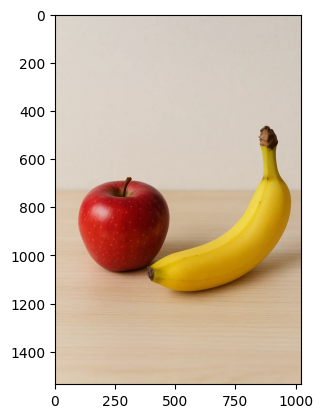

In [17]:
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img = Image.open(test_image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).to(device)

plt.imshow(img)

# Run inference
model.eval()
with torch.no_grad():
    preds = model([img_tensor])

preds = preds[0]

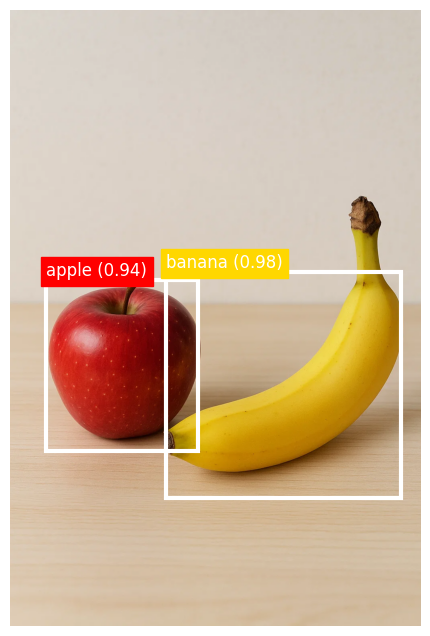

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Extract predictions
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()

# Keep only confident detections
confidence_threshold = 0.5
keep = scores >= confidence_threshold
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

# Labels
label_map = {1: "apple", 2: "banana", 3: "orange"}
colors = {1: 'red', 2: 'gold', 3: 'green'}

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.array(img))

for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=3, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, f"{label_map[label]} ({score:.2f})",
            color='white', fontsize=12, backgroundcolor=colors[label])

plt.axis("off")
plt.show()

In [19]:
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()

confidence_threshold = 0.5
keep = scores >= confidence_threshold

boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

label_map = {1: "apple", 2: "banana", 3: "orange"}

for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    print(f"{label_map[label]} ({score:.2f}), Bounding Box Coordinates "
          f"x={(xmin + xmax)/2:.1f}, y={(ymin+ymax)/2:.1f}, w={(xmax - xmin):.1f}, h={(ymax-ymin):.1f}")

banana (0.98), Bounding Box Coordinates x=681.7, y=935.7, w=585.4, h=563.4
apple (0.94), Bounding Box Coordinates x=279.6, y=886.7, w=379.4, h=426.5
